In [1]:
from __future__ import division, print_function

import os.path

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import numpy.ma as ma
import glob
import matplotlib.colors as colors
from IPython.display import display, Math, Latex

from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import warnings

from salishsea_tools import (
    nc_tools,
    viz_tools,
)
import map

%matplotlib inline

In [2]:
mocC = '/mnt/storage0/jacquielee/research/data/ANHA4-EXH005/moc_ANHA4-EXH005_'
mocJSL = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT002/moc_ANHA4-VJT002_'
mocP  = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT003/moc_ANHA4-VJT003_'

In [3]:
mesh = nc.Dataset('/mnt/storage0/jacquielee/research/data/Jasper/mesh_mask_anha4_201509.nc')
mask = mesh.variables['tmask'][0]
mbathy = ma.array(mesh.variables['mbathy'][0],mask=(mask[0,:,:]-1)*-1)

In [4]:
H=mesh.variables['gdept_0'][0]
nav_lat=mesh.variables['nav_lat']
nav_lon=mesh.variables['nav_lon']
e1t= mesh.variables['e1t'][0,:,:]  # dx
e2t= mesh.variables['e2t'][0,:,:]  # dy 
e3t= mesh.variables['e3t'][0,:,:,:]
volume=e1t*e2t*e3t
volume_density = (volume / np.sum(volume))*100

In [44]:
lat_index = 192
nav_lat = nc.Dataset(mocC+'y2015m07d24.nc').variables['nav_lat'][:,0]

print(nav_lat.shape)

(800,)


In [6]:
def create_moc_timeseries(lat_index, file_loc, yrstart, yrend):
    '''
    this function creates a timeseries of the max moc value at a given latitudinal index
    and between start and end years
    '''
    tlength = (yrend-yrstart)*73
    time_ser = np.zeros(tlength)
    
    tcount = 0
    for year in np.arange(yrstart, yrend):
        for month in np.arange(1, 13):
            for day in np.arange(1, 32):
                f = file_loc+'y'+str(year)+'m'+str(month).zfill(2)+'d'+str(day).zfill(2)+'.nc'
                
                
        
                if os.path.isfile(f):
                    #print(f)
                    time_ser[tcount] = np.amax(nc.Dataset(f).variables['zomsfglo'][0,:,lat_index,0])
                    tcount = tcount+1
    print(f)
    return time_ser
    

In [7]:
mocP_ser = create_moc_timeseries(lat_index, mocP, 2002, 2016)
mocC_ser = create_moc_timeseries(lat_index, mocC, 2002, 2016)
mocJSL_ser = create_moc_timeseries(lat_index, mocJSL, 2002, 2016)

/mnt/storage0/jacquielee/research/data/ANHA4-VJT003/moc_ANHA4-VJT003_y2015m12d31.nc
/mnt/storage0/jacquielee/research/data/ANHA4-EXH005/moc_ANHA4-EXH005_y2015m12d31.nc
/mnt/storage0/jacquielee/research/data/ANHA4-VJT002/moc_ANHA4-VJT002_y2015m12d31.nc


In [8]:
t_labels = ['2002','2003','2004','2005','2006','2007','2008','2009','2010','2011',
           '2012','2013','2014','2015','2016']

Text(0.5,1,u'Max Meriodonal Overturning at 26.5$^{\\circ}$N')

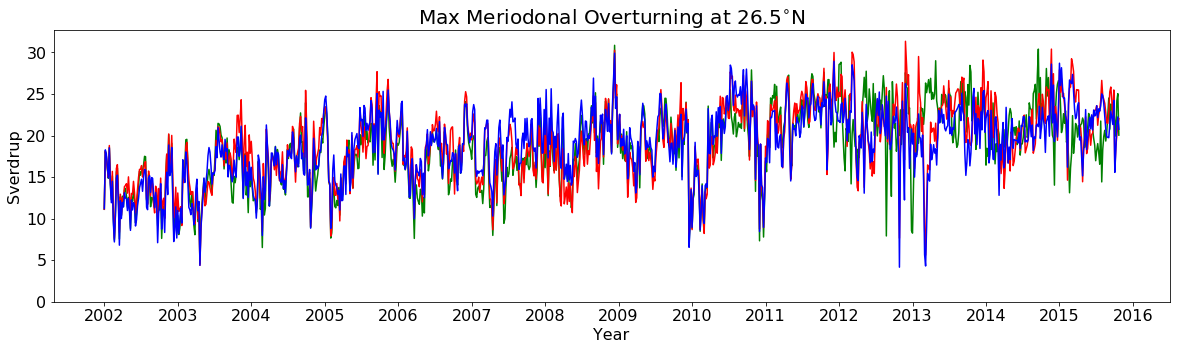

In [19]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(mocP_ser[:-13],color='green')
ax.plot(mocC_ser[:-13],color='red')
ax.plot(mocJSL_ser[:-13],color='blue')

plt.xticks(np.arange(0, len(mocP_ser)+1, 73))
plt.yticks(np.arange(0,35,5), fontsize=16)
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('Sverdrup',fontsize=16)
ax.set_xticklabels(t_labels,fontsize=16)
ax.set_title('Max Meriodonal Overturning at 26.5$^{\circ}$N',fontsize = 20)


In [37]:
def zonal_4yravg(startyr,path,var):
    count = 0
    nrows = 800
    nvert = 50
    
    avg_var = np.zeros((nvert, nrows),dtype=float)
    for year in range(startyr, startyr+4):

        filename = glob.glob(path+'y'+str(year)+'m??d??.nc')

        for f in np.arange(0,len(filename)):
            tracer = nc.Dataset(filename[f])
            variable = tracer.variables[var][0,:,:,0]

            avg_var[:,:] = avg_var[:,:]+variable[:,:]
            count += 1
        #print(avg_var[:,400])

    avg = count*np.ones((nvert, nrows))
    avg_var = ma.array(avg_var/avg)


    netfile = nc.Dataset(path+str(startyr)+'-'+str(startyr+4)+'avg_'+var+'.nc', 'w', format='NETCDF3_64BIT')
    print(path+str(startyr)+'-'+str(startyr+4)+'avg_'+var+'.nc')

    netfile.createDimension('y', nrows)
    netfile.createDimension('z', nvert)
    new_var = netfile.createVariable(var+'four', 'f8', ('z','y'))
    new_var[:,:] = avg_var[:,:]
    netfile.close()
    
    return avg_var

In [38]:
mocC_4yr = zonal_4yravg(2012,mocC,'zomsfglo')
mocP_4yr = zonal_4yravg(2012,mocP,'zomsfglo')
mocJSL_4yr = zonal_4yravg(2012,mocJSL,'zomsfglo')

/mnt/storage0/jacquielee/research/data/ANHA4-EXH005/moc_ANHA4-EXH005_2012-2016avg_zomsfglo.nc
/mnt/storage0/jacquielee/research/data/ANHA4-VJT003/moc_ANHA4-VJT003_2012-2016avg_zomsfglo.nc
/mnt/storage0/jacquielee/research/data/ANHA4-VJT002/moc_ANHA4-VJT002_2012-2016avg_zomsfglo.nc


Text(0.5,1,u'2012-2016 Average MOC Anomoly JSL-Polzin')

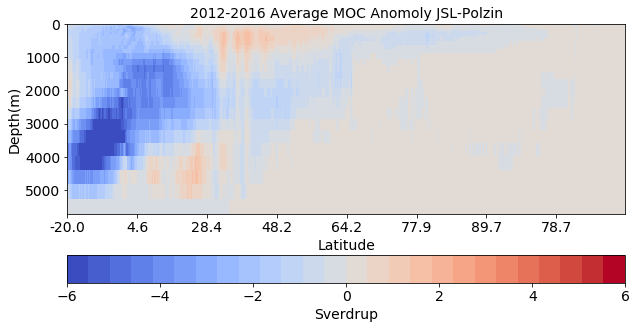

In [80]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(1,1, figsize=(10,5)) 
x = np.arange(0,800)
y = H[:]
X, Y = np.meshgrid(x[:], y[:])
cmap = plt.get_cmap('coolwarm',26)
#cmap.set_bad('0.25',alpha=None)
#norm = colors.PowerNorm(2,vmin=27, vmax=37)
mesh = ax.pcolormesh(X,Y,mocJSL_4yr-mocP_4yr,cmap=cmap,vmax=6,vmin=-6)
plt.ylim(H[0],H[-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.tick_params(axis='y',which='major',labelsize=14)
ax.set_xticklabels(np.round(nav_lat[::100],1),fontsize=14)
ax.set_xlabel('Latitude',fontsize=14)
ax.set_ylabel('Depth(m)',fontsize=14)
#ticks = [27,29,30,31,32,33,34,35,36,37]
bar = plt.colorbar(mesh,orientation='horizontal')
bar.ax.tick_params(labelsize=14)

label='Sverdrup'
#label = '$K_v$'
#label = 'Conservative Temperature Anomaly ($^\circ$C)'
#label = 'Salinity Anomaly (PSU)'
bar.set_label(label,fontsize=14)
bar.update_ticks()
ax.set_title('2012-2016 Average MOC Anomoly JSL-Polzin',fontsize=14)

In [31]:
mocC_4yr[:,400]

masked_array(data = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan],
             mask = False,
       fill_value = 1e+20)